# OLD DATA

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy

from IPython.display import display, HTML
from statsmodels.tsa.seasonal import seasonal_decompose

display(HTML("<style>div.output_scroll { height: 25em; }</style>"))
pd.set_option('display.float_format', '{:.3f}'.format)
sns.set(style="whitegrid")

data = pd.read_csv('../data/transactions_ds.csv', sep=';')

del data['price_ttc']

data['date'] = pd.to_datetime(data['date'])

data['year'] = data['date'].dt.year
data['year_week'] = data['date'].dt.isocalendar().week
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.day_name()

data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute

data['year_week'] = data['year_week'].astype('int64')

In [2]:
calendar = pd.read_json("../data/calendar.json")
weather = pd.read_csv('../data/weather_data.csv', sep=";")

weather['date'] = pd.to_datetime(weather['date'].str[:-6])

weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day
weather['hour'] = weather['date'].dt.hour

data = data.merge(weather, 
                  how='left', 
                  on=['year', 'month', 'day', 'hour'])

<AxesSubplot: xlabel='date', ylabel='temp'>

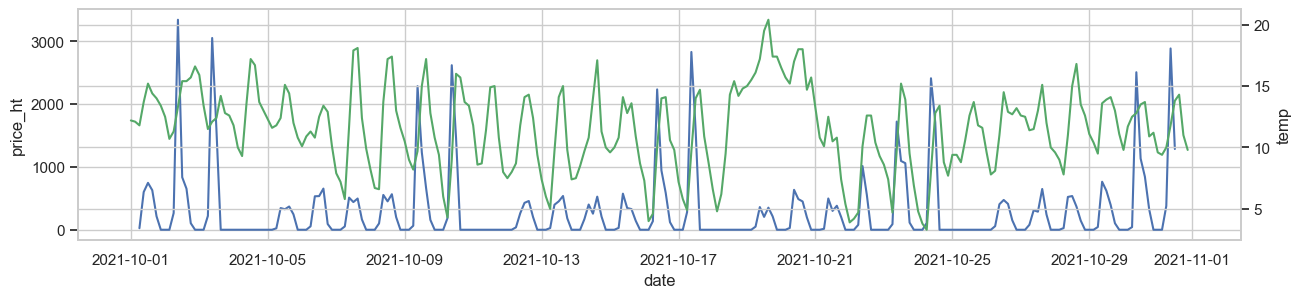

In [4]:
plot_1 = data[(data['year'] == 2021) &
              (data['month'] == 10)].set_index('date').resample('3H')['price_ht'].sum()
plot_2 = weather[(weather['year'] == 2021) &
                 (weather['month'] == 10)].set_index('date').resample('3H').mean()['temp']

fig, ax = plt.subplots(figsize=(15, 3))

sns.lineplot(data=plot_1, color="b")
ax2 = plt.twinx()
sns.lineplot(data=plot_2, color="g", ax=ax2)

# NEW DATA

# Preprocessing

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import warnings

warnings.filterwarnings("ignore")

data = pd.read_csv('../data/stat_222_data/shop_1_transactions.csv', sep=';')

sns.set(style="whitegrid")

del data['price_ttc']

data['date'] = pd.to_datetime(data['date'])

items = pd.read_csv('../data/stat_222_data/shop_1_items_info.csv', sep=';')

calendar = pd.read_json("../data/calendar.json")

weather = pd.read_csv('../data/weather_data.csv', sep=";")

weather['date'] = pd.to_datetime(weather['date'].str[:-6])
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day
weather['hour'] = weather['date'].dt.hour

In [49]:
# Optional chunk
data['year'] = data['date'].dt.year
data['year_week'] = data['date'].dt.isocalendar().week
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.day_name()

data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute

data['year_week'] = data['year_week'].astype('int64')

## Remove outliers

In [50]:
data = data[data['price_ht'] >= 0]
mask = np.abs(scipy.stats.zscore(data[['quantity']])) < 2.5
data = data[mask['quantity']]

data_f = data[~((data['year'] == 2022) & (data['year_week'] > 32)) &
              ~((data['year'] == 2018) & (data['year_week'] < 11))]

# APPROACH 1: PREDICT TREND OF TOTAL SALES AND USE IT AS A COVARIATE FOR PREDICTING SALES OF THE MOST POPULAR GOODS

# Weekly Sales Predictions!

## Approach, discussed with Libor

Here, I take 7 days before and after $Y_t$

Overall approach:

$Y_t = TR_t + Season_t + Z_t$

- Predict $TR_t$ with rolling mean

- Predict $Season_t$ with adding month as a season variable

- Don't think about $Z_t$ for now

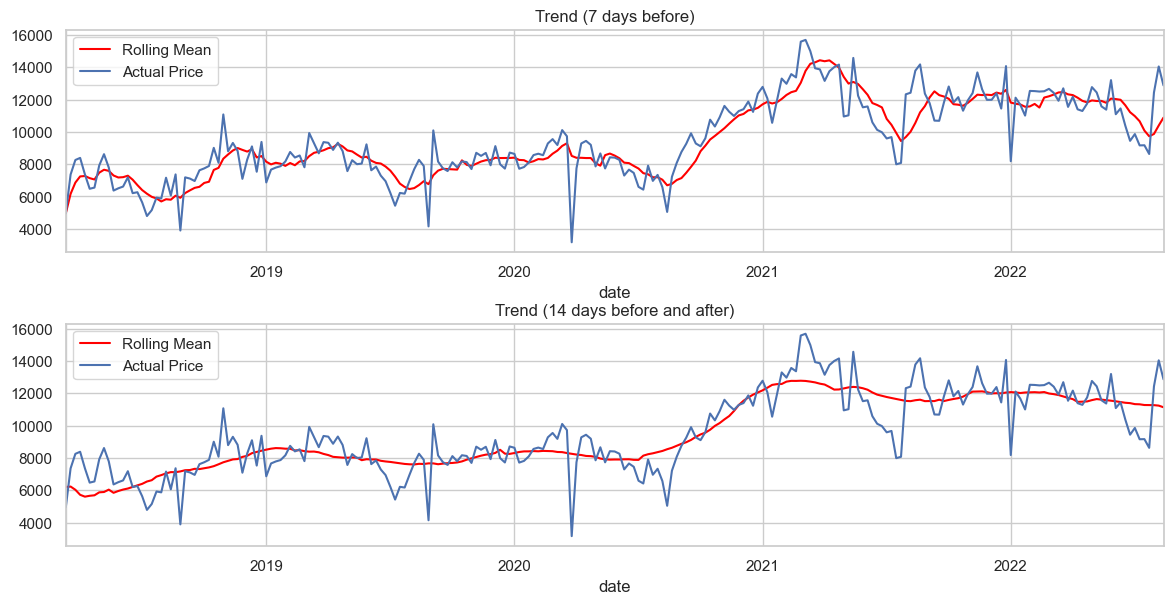

In [214]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

t = 14

sales.rolling(window=7,
              min_periods=1).mean().plot(ax=axs[0], 
                                         title='Trend (7 days before)',
                                         color='red',
                                         xlabel='Date')
sales.plot(ax=axs[0])
axs[0].legend(["Rolling Mean", "Actual Price"])
fig.tight_layout();

sales.shift(-t).rolling(2*t+1, 
                        min_periods=1).mean().plot(ax=axs[1], 
                                                   title=f'Trend ({t} days before and after)',
                                                   color='red',
                                                   xlabel='Date')
sales.plot(ax=axs[1])
axs[1].legend(["Rolling Mean", "Actual Price"]);

In [236]:
trend = sales.shift(-t).rolling(2*t+1, min_periods=1).mean()

sales_no_trend = sales - trend
sales_no_trend.dropna(inplace=True)

In [237]:
sales_no_trend

,price_ht
date,
2018-03-18 00:00:00+00:00,-1243.800000
2018-03-25 00:00:00+00:00,1123.525000
2018-04-01 00:00:00+00:00,2225.360000
2018-04-08 00:00:00+00:00,2665.557500
2018-04-15 00:00:00+00:00,1757.748000
...,...
2022-07-17 00:00:00+00:00,-2112.325789
2022-07-24 00:00:00+00:00,-2645.365000
2022-07-31 00:00:00+00:00,1160.317059


Add additional features: 
1) If national holiday
2) Weather

In [189]:
sales_no_trend = sales_no_trend.reset_index()
sales_no_trend['month'] = sales_no_trend['date'].dt.month

In [190]:
from datetime import timezone

rain = weather.set_index('date').resample('W').mean()['rain'].reset_index()
rain['date'] = rain['date'].dt.tz_localize(timezone.utc)

In [191]:
holidays = calendar[calendar['type'] == 'holidays']
holidays['start_date'] = pd.to_datetime(holidays['start_date'])
holidays['end_date'] = pd.to_datetime(holidays['end_date'])

holidays['start_date'] = holidays['start_date'].dt.tz_localize(timezone.utc)
holidays['end_date'] = holidays['end_date'].dt.tz_localize(timezone.utc)

holidays = holidays[holidays['title'].str.contains('Zone C')]

In [192]:
tmp = sales_no_trend.merge(holidays, how='cross')
tmp = tmp[(tmp['date'] > tmp['start_date']) & 
          (tmp['date'] < tmp['end_date'])][['date', 'title']]

sales_no_trend = sales_no_trend.merge(tmp, how='left').fillna('No')

In [193]:
sales_no_trend = pd.get_dummies(sales_no_trend, columns=['month', 'title'], drop_first=True)

In [195]:
sales_no_trend = sales_no_trend.merge(rain)
del sales_no_trend['date']

In [196]:
import statsmodels.api as sm

X = sales_no_trend.iloc[:,1:]
y = sales_no_trend.price_ht
model_sales = sm.OLS(y, X)

In [197]:
model_sales_fitted = model_sales.fit()
print(model_sales_fitted.summary())

                                 OLS Regression Results                                
Dep. Variable:               price_ht   R-squared (uncentered):                   0.295
Model:                            OLS   Adj. R-squared (uncentered):              0.239
Method:                 Least Squares   F-statistic:                              5.260
Date:                Thu, 04 May 2023   Prob (F-statistic):                    1.18e-09
Time:                        22:22:05   Log-Likelihood:                         -1939.8
No. Observations:                 231   AIC:                                      3914.
Df Residuals:                     214   BIC:                                      3972.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

In [202]:
sales_fit = pd.DataFrame(model_sales_fitted.get_prediction().summary_frame()['mean'])

In [203]:
seasonal_comp = pd.DataFrame(model_sales_fitted.get_prediction().summary_frame()['mean'])
seasonal_comp.index = trend.index

sales_pred = pd.DataFrame(seasonal_comp['mean'] + trend['price_ht'], columns=['price_ht_pred'])

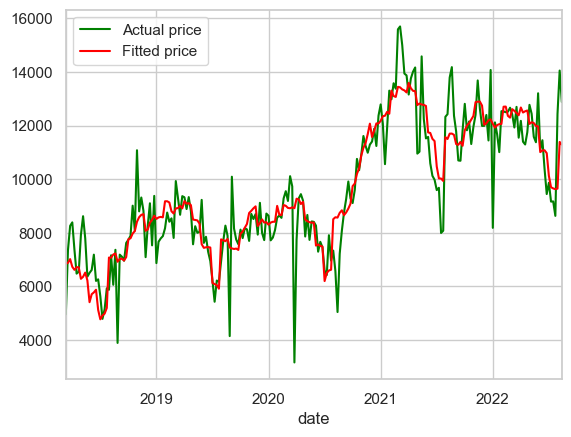

In [204]:
ax = plt.subplot()

sales.plot(ax=ax, color='green')
sales_pred.plot(ax=ax, color='red')
ax.legend(['Actual price', 'Fitted price']);

statsmodels.tsa.stattools.acf(sales['price_ht'] - sales_pred['price_ht_pred'])

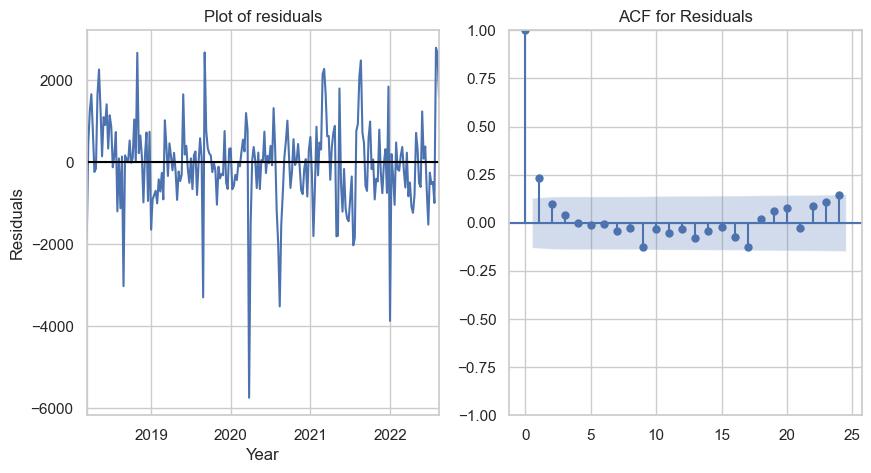

In [205]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

(sales['price_ht'] - sales_pred['price_ht_pred']).plot(title='Plot of residuals',
                                                       ylabel='Residuals',
                                                       xlabel='Year',
                                                       ax=ax[0])

residuals_total_price = (sales['price_ht'] - sales_pred['price_ht_pred'])
ax[0].axhline(color='black')
plot_acf(residuals_total_price, ax=ax[1], title='ACF for Residuals');

Seems we can and need to predict residuals as well to improve quality of prediction

In [206]:
from statsmodels.tsa.ar_model import AutoReg

model_total_sales_res = AutoReg(residuals_total_price, lags=1, trend='n').fit()
print(model_total_sales_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  231
Model:                     AutoReg(1)   Log Likelihood               -1923.819
Method:               Conditional MLE   S.D. of innovations           1038.457
Date:                Thu, 04 May 2023   AIC                           3851.638
Time:                        22:30:38   BIC                           3858.514
Sample:                    03-25-2018   HQIC                          3854.412
                         - 08-14-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.2343      0.064      3.663      0.000       0.109       0.360
                                    Roots                                    
                  Real          Imaginary           M

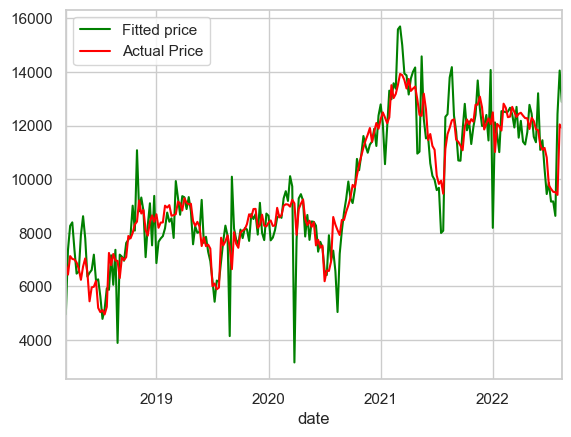

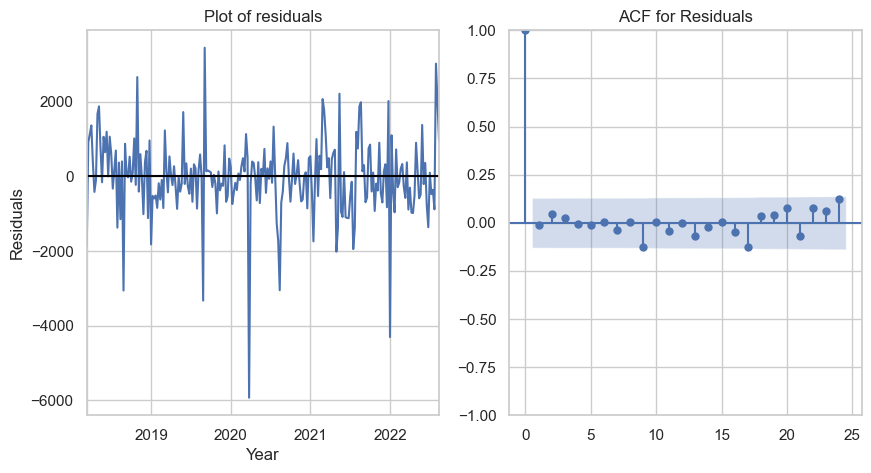

In [210]:
fit_residuals_total_price = model_total_sales_res.get_prediction().summary_frame()['mean'].fillna(0)

sales_pred = pd.DataFrame(seasonal_comp['mean'] + trend['price_ht'] + fit_residuals_total_price, 
                          columns=['price_ht_pred'])


ax = plt.subplot()
sales.plot(ax=ax, color='green')
sales_pred.plot(ax=ax, color='red')
ax.legend(['Fitted price', 'Actual Price']);

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

(sales['price_ht'] - sales_pred['price_ht_pred']).plot(title='Plot of residuals',
                                                       ylabel='Residuals',
                                                       xlabel='Year',
                                                       ax=ax[0])

residuals_total_price = (sales['price_ht'] - sales_pred['price_ht_pred'])
ax[0].axhline(color='black')
plot_acf(residuals_total_price, ax=ax[1], title='ACF for Residuals');

## Prediction for Weekly Sales

### Predict trend

In [234]:
import statsmodels.api as sm

X = [i for i in range(len(sales))]
model_sales = sm.OLS(sales, X).fit()

print(model_sales.summary())

trend_pred = model_sales.get_prediction(max(X) + 1).summary_frame()['mean']

                                 OLS Regression Results                                
Dep. Variable:               price_ht   R-squared (uncentered):                   0.864
Model:                            OLS   Adj. R-squared (uncentered):              0.863
Method:                 Least Squares   F-statistic:                              1456.
Date:                Thu, 04 May 2023   Prob (F-statistic):                   1.81e-101
Time:                        23:10:39   Log-Likelihood:                         -2221.4
No. Observations:                 231   AIC:                                      4445.
Df Residuals:                     230   BIC:                                      4448.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [235]:
trend_pred

0    15880.42432
Name: mean, dtype: float64

### Adjust it for dummies

## Now, let's fit a line for one of the most popular good

In [26]:
temp = data_f.groupby(['item_id'])['transaction_id'].count().sort_values(ascending=False).reset_index()
temp['percentage'] = 100 * temp['transaction_id']  / temp['transaction_id'].sum()
top_5_items = temp[['item_id', 'percentage']].head(5)['item_id'].to_list()
temp[['item_id', 'percentage']].head(5)

,item_id,percentage
0,IT-11,9.801502
1,IT-54,9.421011
2,IT-29,4.741922
3,IT-26,4.663879
4,IT-28,4.491835


In [285]:
IT_11 = data_f[data_f['item_id'] == 'IT-11'][['quantity', 'price_ht', 'date']]
IT_11 = IT_11[['price_ht', 'date']].set_index('date').resample('W').sum()

In [286]:
Y_t = sales_pred.values
Y_t = sm.add_constant(Y_t)
X_t = IT_11.values

model_it11 = sm.OLS(X_t, Y_t)
model_it11_fitted = model_it11.fit()
print(model_it11_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     519.0
Date:                Thu, 04 May 2023   Prob (F-statistic):           8.70e-61
Time:                        20:02:14   Log-Likelihood:                -1530.6
No. Observations:                 231   AIC:                             3065.
Df Residuals:                     229   BIC:                             3072.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -405.5414     53.543     -7.574      0.0

In [287]:
IT_11_pred = pd.DataFrame(model_it11_fitted.get_prediction().summary_frame()['mean'])
IT_11_pred.columns = ['price_ht'] # fitted
IT_11_pred.set_index(IT_11.index, inplace=True)

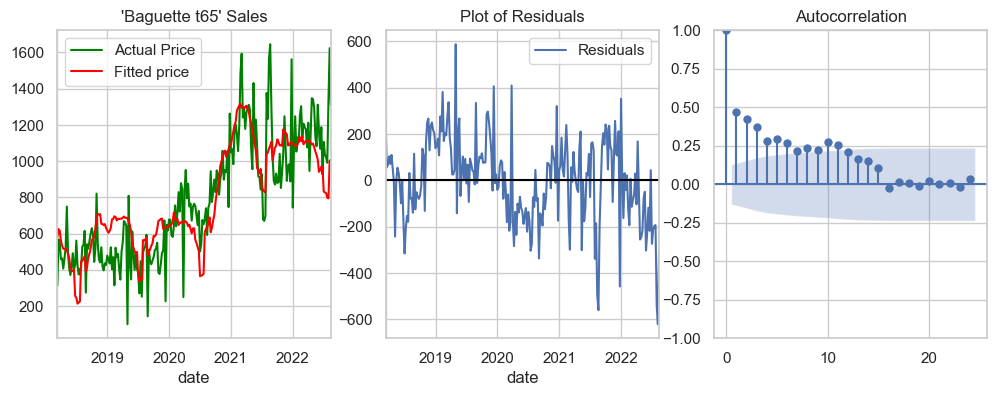

In [290]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

IT_11.plot(ax=ax[0], color='green')
IT_11_pred.plot(ax=ax[0], color='red')
ax[0].set_title(f"'{list(items[items['id'] == 'IT-11']['display_name'])[0]}' Sales")
ax[0].legend(['Actual Price', 'Fitted price'])

(IT_11_pred - IT_11).plot(ax=ax[1]);
ax[1].axhline(y=0, color='black', linestyle='-')
ax[1].set_title('Plot of Residuals')
ax[1].legend(['Residuals'])

plot_acf((IT_11_pred - IT_11), ax=ax[2]);
#plot residuals: any additional seasonal effect?

## Predictions

In [291]:
past_weeks = 5

sales_lw = sales.iloc[-past_weeks:,:]
sales_pred_lw = sales_pred.iloc[-past_weeks:,:]

In [293]:
X = [i for i in range(1, len(sales_lw)+1)]
X = sm.add_constant(X)
Y = sales_lw.values

model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     7.652
Date:                Thu, 04 May 2023   Prob (F-statistic):             0.0698
Time:                        20:03:12   Log-Likelihood:                -42.270
No. Observations:                   5   AIC:                             88.54
Df Residuals:                       3   BIC:                             87.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7584.3240   1537.915      4.932      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [294]:
new_period = np.array([[1, 6]])
X_tplus1 = np.concatenate((X, new_period))

data_tplus1 = pd.DataFrame(results.get_prediction(X_tplus1).summary_frame(alpha=0.05)['mean'])

idx = sales.iloc[-past_weeks:,:].index
idx = idx.union(idx.shift(1)[-1:])
data_tplus1.set_index(idx, inplace=True)

Text(0, 0.5, 'Total sales')

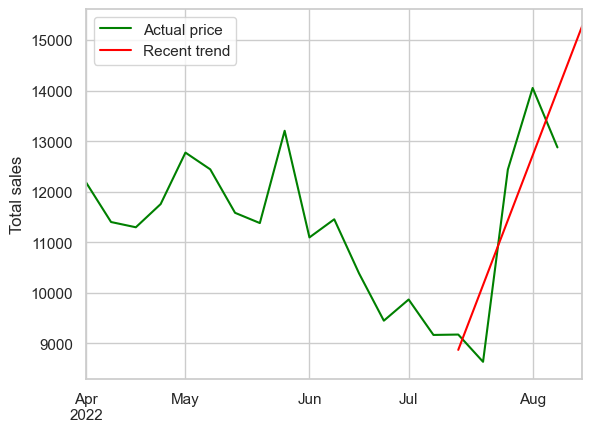

In [295]:
ax = plt.subplot()

sales.iloc[-20:,:].plot(ax=ax, color='green')
data_tplus1.plot(ax=ax, color='red')
ax.legend(['Actual price', 'Recent trend'])
ax.set_xlabel('')
ax.set_ylabel('Total sales')

In [297]:
pred_sales = results.get_prediction(new_period).summary_frame(alpha=0.05)['mean'][0]
y_tp1 = model_it11_fitted.get_prediction(np.array([[1, pred_sales]])).summary_frame()['mean']

idx = IT_11.iloc[-past_weeks:,:].index[-1:]
idx = idx.union(idx.shift(1)[-1:])

data_for_plot = pd.DataFrame({
    'values': [IT_11['price_ht'][-1], y_tp1[0]]
})
data_for_plot.set_index(idx, inplace=True)

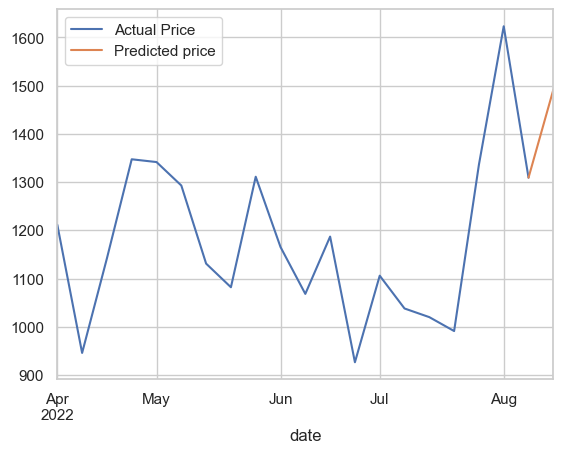

In [298]:
ax = plt.subplot()

IT_11.iloc[-20:,:].plot(ax=ax)
data_for_plot.plot(ax=ax)

ax.legend(['Actual Price', 'Predicted price']);

## Combine the idea for one good to see how it works

In [222]:
past_weeks = 5

predictions = IT_11.iloc[0:past_weeks-1, :]

for i in range(len(sales) - past_weeks + 1):
    
    sales_lw = sales.iloc[i:i+past_weeks, :]
    
    X = [i for i in range(1, len(sales_lw)+1)]
    X = sm.add_constant(X)
    Y = sales_lw.values

    model = sm.OLS(Y, X)
    results = model.fit()
    
    new_period = np.array([[1, past_weeks+1]])
    
    sales_1week_pred = results.get_prediction(new_period).summary_frame(alpha=0.05)['mean'][0]
    item_1week_pred = model_it11_fitted.get_prediction(np.array([[1, sales_1week_pred]])).summary_frame()['mean']
    
    idx = IT_11.iloc[i:i+past_weeks, :].index[-1:]
    
    item_1week_pred = pd.DataFrame({
        'values': [item_1week_pred[0]]
    })
    item_1week_pred.columns = ['price_ht']
    item_1week_pred.set_index(pd.DatetimeIndex(idx), inplace=True)
    
    predictions = pd.concat([
        predictions,
        item_1week_pred
    ])

<AxesSubplot: xlabel='date'>

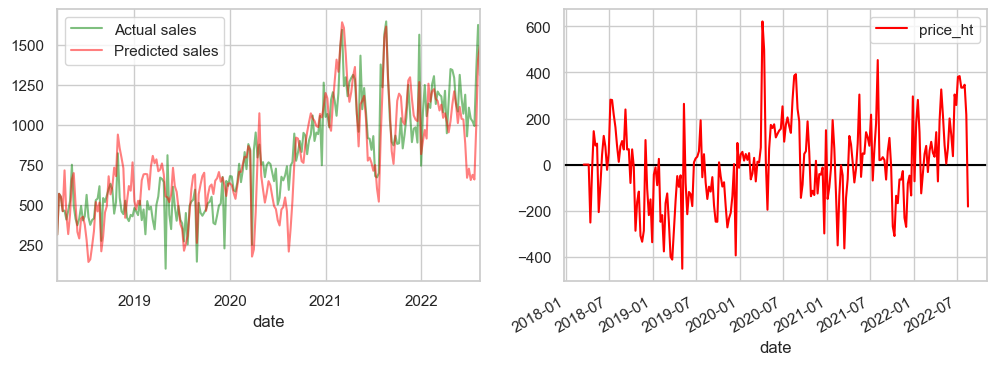

In [260]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
IT_11.plot(ax=ax[0], color='green', alpha=0.5)
predictions.plot(ax=ax[0], color='red', alpha=0.5)
ax[0].legend(['Actual sales', 'Predicted sales'])

residuals = IT_11 - predictions
ax[1].axhline(y=0, color='black', linestyle='-')
residuals.plot(ax=ax[1], color='red')

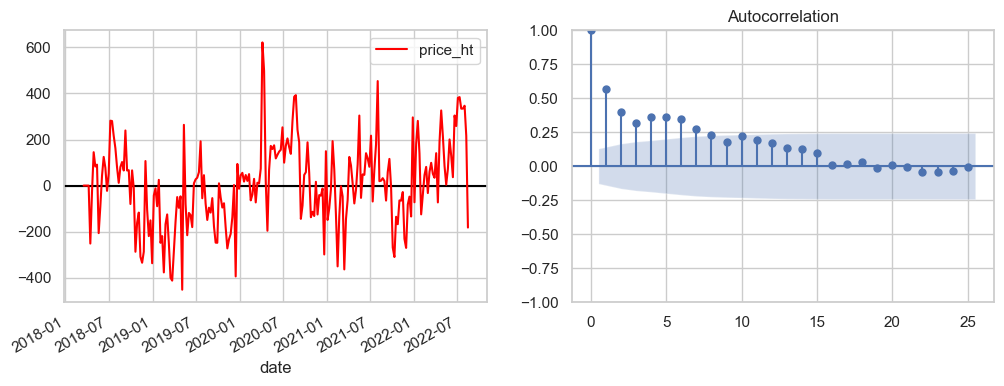

In [264]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].axhline(y=0, color='black', linestyle='-')
(residuals).plot(ax=ax[0], color='red')
plot_acf(residuals, ax=ax[1], lags=25);

In [218]:
import statsmodels

model_residuals = statsmodels.tsa.ar_model.AutoReg(residuals, lags=6, trend='n').fit()
print(model_residuals.summary())

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [308]:
residuals

,price_ht
date,
2018-03-18 00:00:00+00:00,0.000000
2018-03-25 00:00:00+00:00,0.000000
2018-04-01 00:00:00+00:00,0.000000
2018-04-08 00:00:00+00:00,0.000000
2018-04-15 00:00:00+00:00,-251.704914
...,...
2022-07-17 00:00:00+00:00,333.994200
2022-07-24 00:00:00+00:00,334.395354
2022-07-31 00:00:00+00:00,346.805934


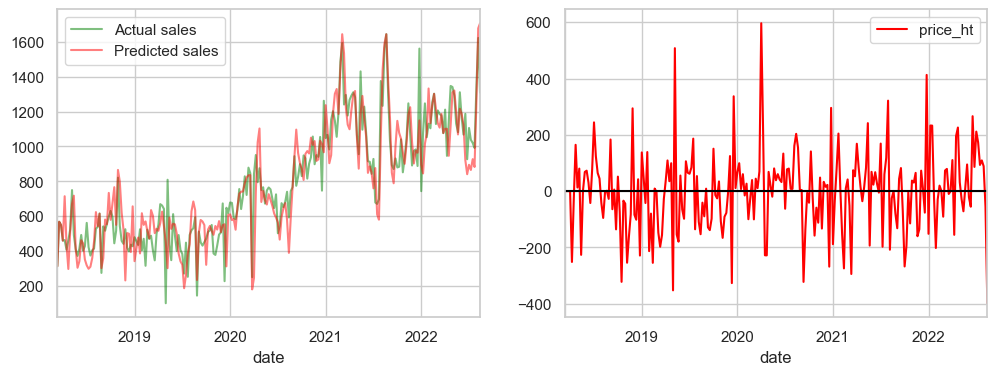

In [325]:
residuals_predictions = pd.DataFrame(model_residuals.get_prediction().summary_frame().fillna(0)['mean'])
residuals_predictions.columns = ['price_ht']

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
IT_11.plot(ax=ax[0], color='green', alpha=0.5)
(predictions + residuals_predictions).plot(ax=ax[0], color='red', alpha=0.5)
ax[0].legend(['Actual sales', 'Predicted sales'])

residuals = IT_11 - (predictions + residuals_predictions)
residuals.plot(ax=ax[1], color='red')
ax[1].axhline(y=0, color='black', linestyle='-')

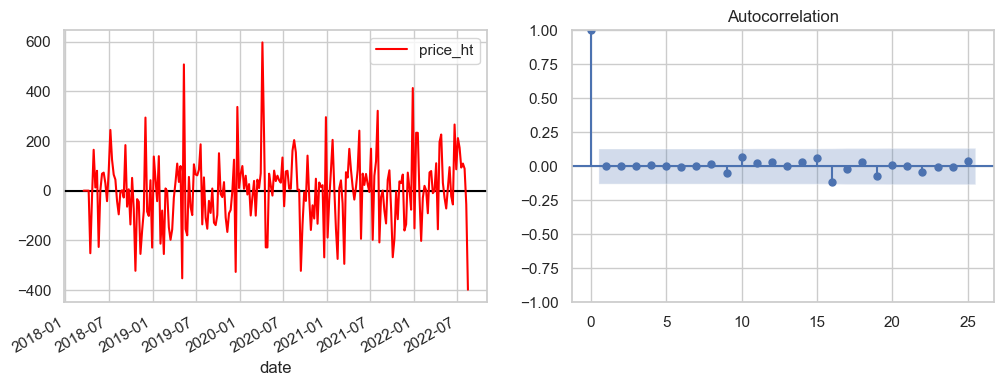

In [324]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].axhline(y=0, color='black', linestyle='-')
(residuals).plot(ax=ax[0], color='red')
plot_acf(residuals, ax=ax[1], lags=25);

In [300]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

model_residuals = ARIMA(sales, order=(1, 0, 0))
model_residuals = mod.fit()



## Get the most popular items

In [354]:
temp = data_f.groupby(['item_id'])['transaction_id'].count().sort_values(ascending=False).reset_index()
temp['percentage'] = 100 * temp['transaction_id']  / temp['transaction_id'].sum()
top_5_items = temp[['item_id', 'percentage']].head(5)['item_id'].to_list()
temp[['item_id', 'percentage']].head(5)

,item_id,percentage
0,IT-11,9.802
1,IT-54,9.421
2,IT-29,4.742
3,IT-26,4.664
4,IT-28,4.492


### IT-11

In [376]:
IT_11 = data_f[data_f['item_id'] == 'IT-11'][['quantity', 'price_ht', 'date']]

# Q_01 = IT_11['quantity'].quantile(0.01)
# Q_99 = IT_11['quantity'].quantile(0.99)

# IT_11 = IT_11[(IT_11['quantity'] > Q_01) &
#               (IT_11['quantity'] < Q_99)]
IT_11 = IT_11[['price_ht', 'date']].set_index('date').resample('W').sum()
IT_11.head(4)

,price_ht
date,
2018-03-18 00:00:00+00:00,312.100
2018-03-25 00:00:00+00:00,567.750
2018-04-01 00:00:00+00:00,549.530
2018-04-08 00:00:00+00:00,458.960


### IT-54

In [375]:
IT_54 = data_f[data_f['item_id'] == 'IT-54'][['quantity', 'price_ht', 'date']]

IT_54 = IT_54[['price_ht', 'date']].set_index('date').resample('W').sum()
IT_54.head(4)

,price_ht
date,
2018-03-18 00:00:00+00:00,263.570
2018-03-25 00:00:00+00:00,426.880
2018-04-01 00:00:00+00:00,335.350
2018-04-08 00:00:00+00:00,313.470


### IT-29

In [377]:
IT_29 = data_f[data_f['item_id'] == 'IT-29'][['quantity', 'price_ht', 'date']]

IT_29 = IT_29[['price_ht', 'date']].set_index('date').resample('W').sum()
IT_29.head(4)

,price_ht
date,
2018-03-18 00:00:00+00:00,251.310
2018-03-25 00:00:00+00:00,440.330
2018-04-01 00:00:00+00:00,394.880
2018-04-08 00:00:00+00:00,419.050


### IT-26

In [378]:
IT_26 = data_f[data_f['item_id'] == 'IT-26'][['quantity', 'price_ht', 'date']]

IT_26 = IT_26[['price_ht', 'date']].set_index('date').resample('W').sum()
IT_26.head(4)

,price_ht
date,
2018-03-18 00:00:00+00:00,299.120
2018-03-25 00:00:00+00:00,499.690
2018-04-01 00:00:00+00:00,569.240
2018-04-08 00:00:00+00:00,495.740


### IT-28

In [379]:
IT_28 = data_f[data_f['item_id'] == 'IT-28'][['quantity', 'price_ht', 'date']]

IT_28 = IT_28[['price_ht', 'date']].set_index('date').resample('W').sum()
IT_28.head(4)

,price_ht
date,
2018-03-18 00:00:00+00:00,220.030
2018-03-25 00:00:00+00:00,459.900
2018-04-01 00:00:00+00:00,400.880
2018-04-08 00:00:00+00:00,462.710


from statsmodels.graphics.tsaplots import plot_acf

plot_acf(IT_11, lags=40);

<AxesSubplot: xlabel='date'>

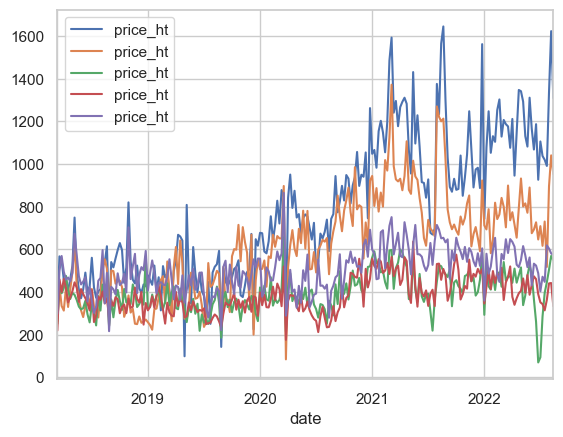

In [388]:
ax = plt.subplot()
IT_11.plot(ax=ax)
IT_54.plot(ax=ax)
IT_29.plot(ax=ax)
IT_28.plot(ax=ax)
IT_26.plot(ax=ax)

In [392]:
Y_t = trend_n_dummy.values
Y_t = sm.add_constant(Y_t)
X_t = IT_11.iloc[3:,:].values

model = sm.OLS(X_t, Y_t)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     543.9
Date:                Tue, 02 May 2023   Prob (F-statistic):           4.43e-62
Time:                        00:01:46   Log-Likelihood:                -1505.9
No. Observations:                 228   AIC:                             3016.
Df Residuals:                     226   BIC:                             3023.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -372.7566     51.127     -7.291      0.0

<AxesSubplot: xlabel='date'>

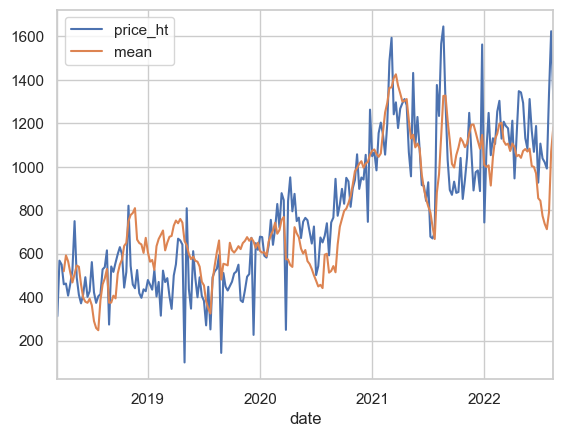

In [412]:
ax = plt.subplot()
IT_11.plot(ax=ax)
pd.DataFrame(results.get_prediction().summary_frame()['mean']).set_index(IT_11.iloc[3:,:].index).plot(ax=ax)

# MA 

In [197]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

mod = ARIMA(sales, order=(2, 3, 1))
res = mod.fit()

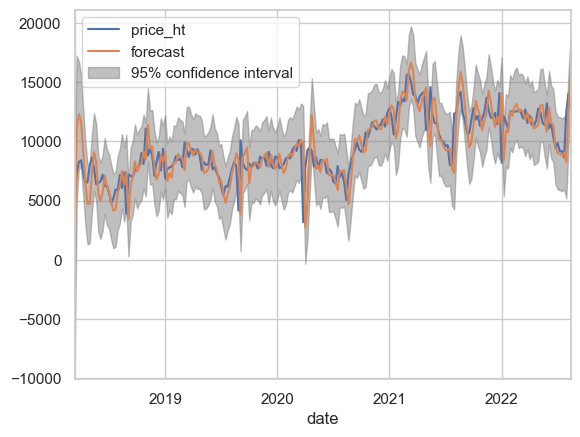

In [198]:
ax = plt.subplot()
sales.plot(ax=ax)
plot_predict(res, ax=ax);

# Test some ideas or functions

## Take future values of rolling

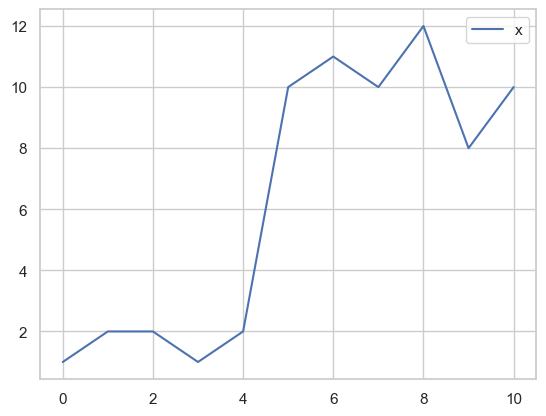

In [87]:
df = pd.DataFrame({
    'x': [1, 2, 2, 1, 2, 10, 11, 10, 12, 8, 10]
})
df.plot();

In [97]:
pd.concat([
    df,
    df.shift(-1).rolling(3, min_periods=1).mean(),
    df.rolling(window=2, min_periods=1).mean().shift(-1)
], axis=1)

,x,x,x
0,1,2.000000,1.5
1,2,2.000000,2.0
2,2,1.666667,1.5
3,1,1.666667,1.5
4,2,4.333333,6.0
5,10,7.666667,10.5
6,11,10.333333,10.5
7,10,11.000000,11.0
8,12,10.000000,10.0
9,8,10.000000,9.0


## Get total sales

sales = data_f[['price_ht', 'date']].set_index('date').resample('W').sum()
sales.plot();

Very unstable trend, remove outliers

Q95 = data_f['price_ht'].quantile(0.95)
Q05 = data_f['price_ht'].quantile(0.05)

data_f = data_f[(data_f['price_ht'] < Q95) &
                (data_f['price_ht'] > Q05)]

sales = data_f[['price_ht', 'date']].set_index('date').resample('W').sum()
sales.plot();

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 5))

sales.diff().plot(title='First lag of total sales', ax=ax1)
plot_acf(sales.diff().dropna(), title='ACF plot', ax=ax2, lags=60)
plot_pacf(sales.diff().dropna(), title='PACF plot', ax=ax3, lags=60, method='ywm');

from statsmodels.tsa.stattools import kpss, adfuller

<center>KPSS test:</center>
$$
H_0: \text{The process is trend stationary}\\
H_1: \text{The series has a unit root}
$$

kpss(sales.diff().dropna())[1]

<center>ADF test:</center>
$$
H_0: \text{Has unit root process}\\
H_1: \text{Has no unit root process}
$$

### Some random ARIMA model

from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

model = ARIMA(sales, order=(3,4,1))
model_fit = model.fit()

print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
print(residuals.describe())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
residuals.plot(ax=ax1)
residuals.plot(kind='kde', ax=ax2);